In [1]:
import os

os.chdir("..")
%load_ext autoreload

In [3]:
import warnings
import matplotlib.pyplot as plt
import shutil
import comet_ml
import numpy as np
import seaborn as sb
import pandas as pd
import torch
from monai.transforms import Rotate90, Compose
from sklearn.metrics import r2_score

warnings.simplefilter("ignore")
api = comet_ml.api.API(
    api_key="WmA69YL7Rj2AfKqwILBjhJM3k",
)

## Analysis of discrete labelling

In [7]:
drop = pd.read_csv(r"/home/chbricout/Downloads/MRART-pred.csv")
# drop['count']=drop['count'].apply(eval)
# drop['max classe']=drop['count'].apply(np.argmax)
# drop['labels']=drop['labels'].astype(int)
# drop['confidence']=drop['count'].apply(max)
drop

,Unnamed: 0,pred,identifier,label,mode
0,0,0.032810,sub-000159_ses-standard,0,train
1,1,0.082148,sub-000159_ses-headmotion1,2,train
2,2,0.099937,sub-000159_ses-headmotion2,2,train
3,3,0.014550,sub-000175_ses-standard,0,train
4,4,0.026219,sub-000175_ses-headmotion1,1,train
...,...,...,...,...,...
342,84,0.059089,sub-750675_ses-headmotion1,2,val
343,85,0.093406,sub-750675_ses-headmotion2,2,val
344,86,0.047022,sub-862915_ses-standard,0,val
345,87,0.090425,sub-862915_ses-headmotion1,2,val


In [14]:
base_accuracy = (drop['labels'] == drop['mean'].astype(int)).sum() / len(drop)
base_accuracy

0.797752808988764

In [30]:
def get_prop_acc(df:pd.DataFrame, confidence:int):
    filtered = df[df['confidence']>=confidence]
    filtered_accuracy = (filtered['labels'] == filtered['max classe'].astype(int)).sum() / len(filtered)
    filtered_prop = len(filtered)/len(df)
    return filtered_accuracy, filtered_prop

In [37]:
get_prop_acc(drop, 100)

(0.8448275862068966, 0.651685393258427)

In [33]:
accs = []
props = []
for i in range(50,101):
    (a,p)=get_prop_acc(drop, confidence=i)
    accs.append(a)
    props.append(p)

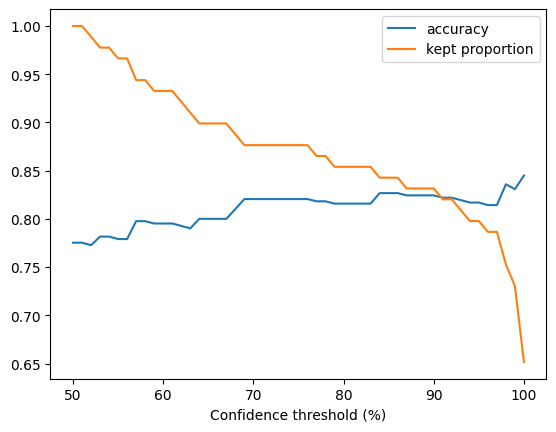

In [36]:
plt.plot(range(50,101),accs, label="accuracy")
plt.plot(range(50,101),props, label="kept proportion")
plt.xlabel("Confidence threshold (%)")
plt.legend()

Text(0.5, 1.0, 'Label against Prediction with 100% confidence')

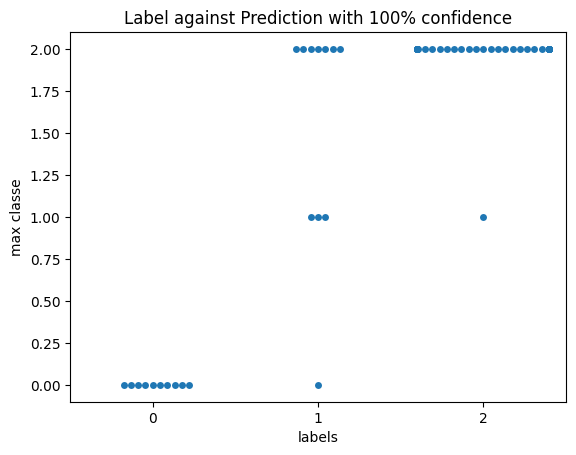

In [41]:
sb.swarmplot(drop[drop['confidence']>=100], x="labels", y="max classe")
plt.title("Label against Prediction with 100% confidence")

## Analysis of continuous labelling

Max r2 is 0.8586616516113281

,Unnamed: 0,identifier,mean,std,label,predictions
0,0,BI07844_202305241-0,0.031399,0.003885,0.035504,"[0.02798493392765522, 0.02627989836037159, 0.0..."
1,1,BM97794_202305241-0,0.003380,0.001917,0.009384,"[0.002534660277888179, 0.0031958785839378834, ..."
2,2,KC05926_202305261-0,0.097014,0.007451,0.079604,"[0.09916261583566666, 0.08642863482236862, 0.0..."
3,3,LA21640_202308021-0,0.097126,0.004100,0.098582,"[0.09908313304185867, 0.09563527256250381, 0.0..."
4,4,ME04106_202211181-0,0.136485,0.006381,0.134101,"[0.1280687153339386, 0.1433190405368805, 0.144..."
...,...,...,...,...,...,...
3520,3520,TE04070_202212081-299,0.031147,0.004216,0.034701,"[0.03608034551143646, 0.033019207417964935, 0...."
3521,3521,WU09114_202301101-299,0.022610,0.003708,0.005568,"[0.02654622681438923, 0.016712451353669167, 0...."
3522,3522,1025_1-299,0.001327,0.001802,0.005076,"[0.00194784183986485, 0.0026160567067563534, 0..."
3523,3523,1143_1-299,0.209126,0.008172,0.214643,"[0.21531932055950165, 0.20536823570728302, 0.2..."


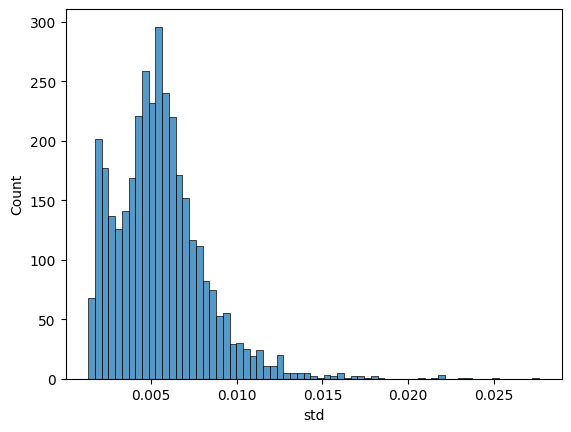

In [29]:
drop = pd.read_csv(r"/home/chbricout/Downloads/mcdropout-res.csv")
sb.histplot(drop, x="std")
drop

In [23]:
def get_prop_mse_r2(df:pd.DataFrame, std:float):
    filtered = df[df['std']<=std]
    if len(filtered)==0:
        return 0,1,0
    mse = ((filtered['mean']-filtered['label'])**2).mean()
    r2 = r2_score(filtered['label'], filtered['mean'])
    filtered_prop = len(filtered)/len(df)
    return mse, r2, filtered_prop

In [24]:
mses = []
r2s = []
props = []
x=np.arange(0.00,0.023, 0.001)

for i in x:
    (m,r,p)=get_prop_mse_r2(drop, i)
    mses.append(m)
    r2s.append(r)
    props.append(p)

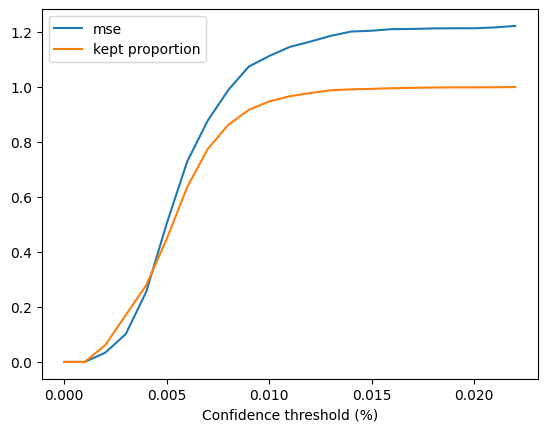

In [30]:
plt.plot(x,np.array(mses)*5000, label="mse")
# plt.plot(x,r2s, label="r2")
plt.plot(x,props, label="kept proportion")
plt.xlabel("Confidence threshold (%)")
plt.legend()